This notebook is for finding those autoinhibitory proteins with only two annotated domains from UniProt

In [9]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator

In [10]:
def string2range(x):
    
    """
    This function takes in a `string` representing a region of interest in a
    protein. The region of interest can be a single region or multiple regions
    of a protein. Returns a range for single regions or a list of ranges for
    multiple regions.
    
    Parameters:
    
        x (string): String containing a region or several regions of interest in a 
            protein.
            Format of x: single region -> 'start-end'
                         multiple regions -> 'start1-end1,start2-end2'
                     
    Returns:
    
        range or list of ranges: For single region proteins a range is returned. For 
            multiple region proteins a list of ranges is returned

            Format: single region -> range(start, end+1)
                    multiple region -> [range(start1, end1+1), range(start2, end2+1)]
    """
    # Handle instances with more than one range
    if ',' in x:
        list_temp = x.split(sep = ',') #list_temp = ['123-456,' '789-1111']
        for y in range(len(list_temp)): 
            list_temp[y] = list_temp[y].split(sep = '-') #list_temp[y] = [['123', '456'], ['789', '1111']]
        for y in range(len(list_temp)): 
            for x in range(len(list_temp[y])):
                list_temp[y][x] = int(list_temp[y][x]) #turns each list item into an integer

        # Make a range object with the bounds of the range. Note to the 
        # end a 1 has to be added in order to include the last position in the range
        for y in range(len(list_temp)): #[1, 2] where 1=[123, 456] and 2=[789, 1111]
            for x in range(len(list_temp[y])): #[123, 456]       
                list_temp[y] = list(range(list_temp[y][x], list_temp[y][x+1]+1)) #list_temp[0][0] = [123], list_temp[0][0+1]+1 or [456] + 1 = [457]
                break

        return list(set([item for sublist in list_temp for item in sublist]))

    # Handle instances with only one range
    else:
        list_temp = x.split(sep = '-')
        for y in range(len(list_temp)):
            list_temp[y] = int(list_temp[y]) #

        # Make a range object with the bounds of the region. Note to the 
        # end a 1 has to be added in order to include the last position in the range
        return list(range(list_temp[0], list_temp[1]+1))

def get_domains(uniprot_id):
    '''
    Get the domain information from UniProtKB
    '''
    print(f'Getting domains for {uniprot_id}')
    url = f'https://rest.uniprot.org/uniprotkb/search?query=accession:{uniprot_id}&fields=ft_domain'
    response = requests.get(url)
    response_dic = response.json()
    domains = []
    try:
        features = response_dic['results'][0]['features']
        # Get the start and end of any domains
        for i in range(len(features)):
            if response_dic['results'][0]['features'][0]['type'] == 'Domain':
                start = str(features[i]['location']['start']['value'])
                end = str(features[i]['location']['end']['value'])
                domains.append((start + '-' + end))

        domains_string = ','.join(domains)

    except KeyError:
        print(f'No domains found for {uniprot_id}')
        domains_string = None

    if domains_string == '':
        domains_string = None

    return domains_string

def overlap(range1, range2):
    '''
    Check if two regions overlap by at least 90%. region_1 and region_2 are both lists
    '''
    print(min(range1), max(range1), min(range2), max(range2))

    common = set(range1).intersection(set(range2))

    if len(common) >= 0.9 * min(len(range1), len(range2)):
        return True

    else:
        return False

def compare_domains(row):

    # Get the uniprot ID and domains as ranges
    uniprot_id = row['uniprot']
    region_1_range = string2range(row['region_1'])
    region_2_range = string2range(row['region_2'])

    # Get the domains from UniProtKB
    domains = get_domains(uniprot_id)

    # For each domain in domains, check if it overlaps with region_1 or region_2. If any region does not
    # overlap by at least 90% with any domain, return row['has_extra'] as True
    overlapping_domains = []
    extra_domains = []

    print(f'Comparing domains for {uniprot_id}')

    if domains is not None:
        domains = domains.split(',')
        for domain in domains:
            domain_range = string2range(domain)
            if overlap(region_1_range, domain_range) == False and overlap(region_2_range, domain_range) == False:
                extra_domains.append(domain)
            elif overlap(region_1_range, domain_range) or overlap(region_2_range, domain_range):
                overlapping_domains.append(domain)

        if len(extra_domains) >= 1:
            row['has_extra'] = True

        else:
            row['has_extra'] = False
        
        row['overlapping_domains'] = ','.join(overlapping_domains)
        row['extra_domains'] = extra_domains
        row['uniprot_domains'] = domains
    
    else:
        row['has_extra'] = False
        row['overlapping_domains'] = np.nan
        row['extra_domains'] = np.nan
        row['uniprot_domains'] = np.nan

    return row



In [11]:
df = pd.read_csv('./project_pipeline/data/classified_files.tsv', sep='\t')

per_prot = df[['uniprot', 'region_1', 'region_2']].drop_duplicates().reset_index(drop=True)

per_prot = per_prot.apply(compare_domains, axis=1)
per_prot.head()

Getting domains for P04637
Comparing domains for P04637
Getting domains for P07038
Comparing domains for P07038
Getting domains for Q8NQJ3
Comparing domains for Q8NQJ3
1 40 68 117
68 117 68 117
1 40 68 117
68 117 68 117
Getting domains for P00579
Comparing domains for P00579
Getting domains for P60240
Comparing domains for P60240
1 110 164 334
147 659 164 334
1 110 164 334
147 659 164 334
1 110 490 662
147 659 490 662
1 110 490 662
147 659 490 662
Getting domains for P14633
Comparing domains for P14633
Getting domains for A0A0R4I961
Comparing domains for A0A0R4I961
155 279 3 147
3 147 3 147
155 279 3 147
3 147 3 147
155 279 160 279
155 279 160 279
Getting domains for P00523
Comparing domains for P00523
148 266 81 142
81 533 81 142
148 266 81 142
81 533 81 142
148 266 148 245
148 266 148 245
148 266 267 520
81 533 267 520
Getting domains for Q00944
Comparing domains for Q00944
35 362 35 355
35 362 35 355
35 362 422 680
422 680 422 680
35 362 422 680
422 680 422 680
Getting domains for Q

,uniprot,region_1,region_2,has_extra,overlapping_domains,extra_domains,uniprot_domains
0,P04637,364-393,102-292,False,NaN,NaN,NaN
1,P07038,892-917,562-625,False,NaN,NaN,NaN
2,Q8NQJ3,1-40,68-117,False,68-117,[],[68-117]
3,P00579,2-80,"379-449,458-534",False,NaN,NaN,NaN
4,P60240,1-110,"147-416,441-659",False,"164-334,490-662",[],"[164-334, 490-662]"


In [12]:
per_prot['has_extra'].value_counts()

False    69
True     59
Name: has_extra, dtype: int64

In [43]:
lengths = pd.read_csv('./project_pipeline/data/proteins_by_pdb.tsv', sep='\t')[['uniprot', 'protein_length']].drop_duplicates().reset_index(drop=True)


df2 = pd.merge(per_prot, lengths, how='left', on='uniprot').drop(columns=['region_1', 'region_2'])
df2.head()
df2.to_csv('./project_pipeline/data/extra_domains.csv', sep=',', index=False)

,uniprot,has_extra,overlapping_domains,extra_domains,uniprot_domains,protein_length
1,P07038,False,NaN,NaN,NaN,920.0
2,Q8NQJ3,False,68-117,[],[68-117],143.0
3,P00579,False,NaN,NaN,NaN,613.0
4,P60240,False,"164-334,490-662",[],"[164-334, 490-662]",NaN
10,P28482,False,25-313,[],[25-313],360.0
11,P62826,False,NaN,NaN,NaN,216.0
17,P12931,True,"84-145,151-248",[270-523],"[84-145, 151-248, 270-523]",536.0
29,P22681,True,,"[47-351, 856-895]","[47-351, 856-895]",906.0
34,P21333,True,,"[43-149, 166-269]","[43-149, 166-269]",2647.0
40,Q9Y6K1,True,"482-614,634-912",[292-350],"[292-350, 482-614, 634-912]",912.0


<Axes: xlabel='has_extra', ylabel='protein_length'>

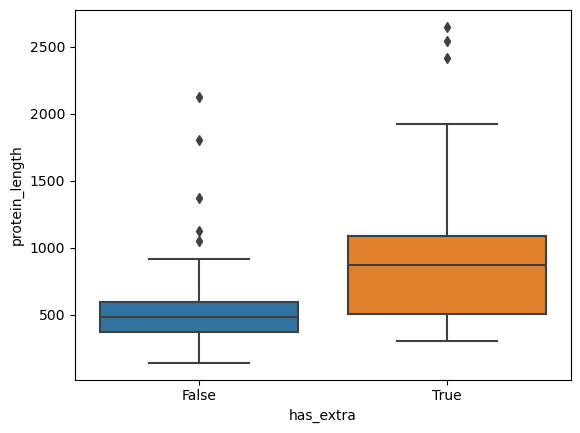

In [14]:
sns.boxplot(data=df2, x='has_extra', y='protein_length')

In [15]:
df3 = pd.merge(df2, df, how='left', on='uniprot')
df3.head()

,uniprot,has_extra,overlapping_domains,extra_domains,uniprot_domains,protein_length,pdb,region_1,region_2,complex_rmsd,...,percent_region_2,2_aligned,2_comp,state,conformation,organism,date,notes,chain,af_filename
0,P04637,False,NaN,NaN,NaN,393.0,8f2h,364-393,102-292,30.431,...,100.0,3.065,70.729,Autoinhibited,Closed,"""Homo sapiens""",['2022-11-08'],NaN,A,F-P04637-F1-model_v3.cif
1,P04637,False,NaN,NaN,NaN,393.0,8f2i,364-393,102-292,30.431,...,100.0,3.065,70.729,Autoinhibited,Closed,"""Homo sapiens""",['2022-11-08'],NaN,A,F-P04637-F1-model_v3.cif
2,P07038,False,NaN,NaN,NaN,920.0,1mhs,892-917,562-625,14.225,...,100.0,8.246,22.815,Active,Closed,"""Neurospora crassa""",['2002-08-21'],NaN,A,F-P07038-F1-model_v3.cif
3,P07038,False,NaN,NaN,NaN,920.0,7nxf,892-917,562-625,4.914,...,100.0,1.812,12.107,Autoinhibited,Closed,"""Neurospora crassa""",['2021-03-18'],“Phosphorylation of Ser913/Thr914 would distur...,A,F-P07038-F1-model_v3.cif
4,P07038,False,NaN,NaN,NaN,920.0,7ny1,892-917,562-625,4.914,...,100.0,1.812,12.107,Autoinhibited,Closed,"""Neurospora crassa""",['2021-03-19'],NaN,A,F-P07038-F1-model_v3.cif


In [41]:
two_state = pd.read_csv('./two_state_proteins_for_jp.csv')

two_state_extra_domains = df3[df3['uniprot'].isin(two_state['UniProt'].unique().tolist())].drop_duplicates(subset='uniprot')
two_state_extra_domains

,uniprot,has_extra,overlapping_domains,extra_domains,uniprot_domains,protein_length,pdb,region_1,region_2,complex_rmsd,...,percent_region_2,2_aligned,2_comp,state,conformation,organism,date,notes,chain,af_filename
2,P07038,False,NaN,NaN,NaN,920.0,1mhs,892-917,562-625,14.225,...,100.000000,8.246,22.815,Active,Closed,"""Neurospora crassa""",['2002-08-21'],NaN,A,F-P07038-F1-model_v3.cif
5,Q8NQJ3,False,68-117,[],[68-117],143.0,2kb3,1-40,68-117,15.371,...,100.000000,2.552,29.829,Autoinhibited,Closed,Corynebacterium glutamicum,['2008-11-20'],NaN,A,F-Q8NQJ3-F1-model_v3.cif
7,P00579,False,NaN,NaN,NaN,613.0,4llg,2-80,"379-449,458-534",13.459,...,100.000000,1.750,45.352,Active,Open,Enterobacteria phage T7,['2013-07-09'],NaN,F,F-P00579-F1-model_v3.cif
13,P60240,False,"164-334,490-662",[],"[164-334, 490-662]",NaN,4s20,1-110,"147-416,441-659",11.120,...,99.795501,3.080,29.595,Autoinhibited,Closed,Escherichia coli,['2015-01-16'],NaN,K,F-P60240-F1-model_v3.cif
25,P28482,False,25-313,[],[25-313],360.0,1pme,173-196,"25-172,197-313",2.422,...,96.603774,1.220,6.639,Autoinhibited,Closed,Homo sapiens,['1998-06-08'],NaN,A,F-P28482-F1-model_v3.cif
145,P62826,False,NaN,NaN,NaN,216.0,1k5d,179-216,10-169,13.757,...,100.000000,2.235,34.225,Active,Closed,Homo sapiens,['2001-10-10'],NaN,A,F-P62826-F1-model_v3.cif
391,P12931,True,"84-145,151-248",[270-523],"[84-145, 151-248, 270-523]",536.0,1fmk,"249-269,151-248","84-145,524-536",1.857,...,96.000000,3.709,7.045,Autoinhibited,Closed,Homo sapiens,['1997-01-24'],NaN,A,F-P12931-F1-model_v3.cif
610,P22681,True,,"[47-351, 856-895]","[47-351, 856-895]",906.0,1fbv,353-380,381-435,24.937,...,98.181818,5.263,34.316,Autoinhibited,Closed,Homo sapiens,['2000-07-17'],NaN,A,F-P22681-F1-model_v3.cif
663,P21333,True,,"[43-149, 166-269]","[43-149, 166-269]",2647.0,2j3s,2142-2235,2236-2325,10.018,...,100.000000,2.112,21.192,Autoinhibited,Closed,HOMO SAPIENS,['2006-08-23'],NaN,A,F-P21333-F1-model_v3.cif
689,Q9Y6K1,True,"482-614,634-912",[292-350],"[292-350, 482-614, 634-912]",912.0,4u7p,476-626,634-912,15.705,...,95.340502,1.385,47.330,Autoinhibited,Closed,Homo sapiens,['2014-07-31'],NaN,A,F-Q9Y6K1-F1-model_v3.cif


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:1.738e-08 U_stat=1.144e+05


(<Axes: xlabel='has_extra', ylabel='complex_rmsd'>,
 [<statannotations.Annotation.Annotation at 0x7f796ce81610>])

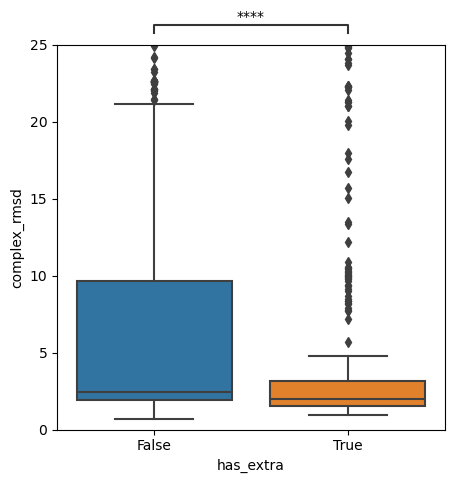

In [26]:
fig, ax = plt.subplots(figsize=(5, 5))

sns.boxplot(data=df3, x='has_extra', y='complex_rmsd', ax = ax)
ax.set_ylim(0, 25)

pairs = [(True, False)]
order = [False, True]
annotator = Annotator(ax, pairs, data=df3, x='has_extra', y='complex_rmsd')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

In [29]:
df3.groupby('has_extra')['complex_rmsd'].describe()

,count,mean,std,min,25%,50%,75%,max
has_extra,,,,,,,,
False,561.0,6.251551,7.011978,0.712,1.898,2.408,9.630,30.770
True,333.0,5.064174,8.992256,0.922,1.505,1.984,3.179,113.774


In [56]:
sub = df[['uniprot', 'region_1', 'region_2']].drop_duplicates().reset_index(drop=True)
sub.to_csv('./all_proteins_for_jp.csv', index=False, sep=',')